<center> 
    <img src="./logo_UTN.svg" height=”300” width=200”>
</center>

<h1><center> TAREA SEMANAL 3 <center></h1>
    <h2><center> TEORIA DE LOS CIRCUITOS 2<center></h2>
    <h3>Destefano, Martin</h3>
        
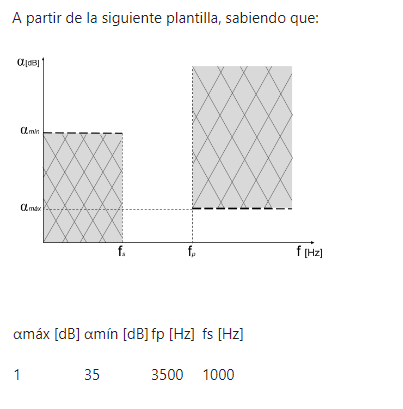

Antes que nada obtendremos la plantilla pasabajos, para esto: 

$$ \omega_{pn} = \frac{\omega{p}}{\omega{p}} $$  
$$ \omega_{sn} = \frac{\omega{s}}{\omega{p}} $$ 

Para el pasabajos: 

$$ \Omega_{P} = 1 $$
$$ \Omega_{S} = 3.5 = \frac{1}{\omega_{Sn}} $$ 


In [35]:
# Calculo epsilon y orden 

import numpy as np 
import scipy.signal as sig 
import math as m 

alfa_max = 1
ws = 2*m.pi*1000 
wp = 2*m.pi*3500

wp_n = 1 
ws_n = ws/wp

ws_lp = 1/ws_n

# cuentas auxiliares

ee = 10**(alfa_max/10)-1

for nn in range(2,6):
    
    alfa_min_b = 10*np.log10(1 + ee * ws_lp**(2*nn))
    alfa_min_c = 10*np.log10(1 + ee * np.cosh(nn * np.arccosh(ws_lp))**2 )
    
    print( 'nn {:d} - alfa_min_butter {:f} - alfa_min_cheby {:f}'.format(nn, alfa_min_b, alfa_min_c) )
print (ee)

nn 2 - alfa_min_butter 16.004828 - alfa_min_cheby 21.583370
nn 3 - alfa_min_butter 26.784944 - alfa_min_cheby 38.268911
nn 4 - alfa_min_butter 37.657935 - alfa_min_cheby 54.987207
nn 5 - alfa_min_butter 48.538612 - alfa_min_cheby 71.706203
0.2589254117941673


Como observamos, con la aproximacion de Chebyshev tendriamos un orden menor de implementacion, pero el ejercicio nos pide maxima planicidad (Butterworth) por lo tanto tomaremos un n = 4 y un $\varepsilon^2 = 0.2589$. 

Sabemos que tendremos 4 polos y la aproximacion es de tipo Butterworth: 

$$ |T(S)|^2 = \frac{1}{1+\varepsilon^2\omega^{2*4}} $$

El calculo manual seria engorroso ya que tendriamos que hacer muchos despejes, por lo tanto: 

Conocemos los angulos de los polos que seran complejos conjugados:  $\psi_{1} = \pi/8$ y $\psi_{2} = \pi/8 + \pi/4 = 3\pi/8$

Los calculo con roots: 

In [36]:
import scipy.signal as sig

p = np.roots([ee,0,0,0,0,0,0,0,1])
for i in range(0,7):
    print(p[i])


(-1.093877051815626+0.45309871043072875j)
(-1.093877051815626-0.45309871043072875j)
(-0.45309871043072875+1.0938770518156256j)
(-0.45309871043072875-1.0938770518156256j)
(0.4530987104307296+1.093877051815624j)
(0.4530987104307296-1.093877051815624j)
(1.0938770518156247+0.4530987104307287j)


Me quedo solo con los polos en el semiplano izquierdo, y con estos saco denominador y numerador mediante Python 

In [37]:
import scipy.signal as sig

p_norm = [p[0], p[1], p[2], p[3]]

num,den = sig.zpk2tf([],p_norm,1)

print(num)
print(den)

[1.]
[1.         3.09395152 4.78626802 4.33730373 1.96522673]


Por lo tanto la transferencia pasabajos queda: 

$$ T(S)_{LP} = \frac{1}{S^4+3.09395152S^3+4.78626802S^2+4.33730373S+1.96522673} $$

Antes de continuar comprobamos que haya sido correcto: 


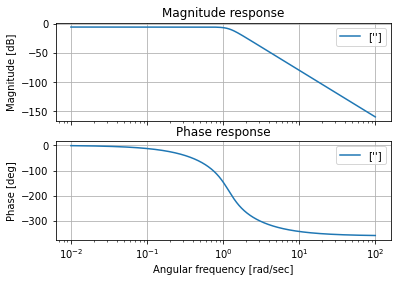

In [38]:
import numpy as np 
import scipy.signal as sig 
import math as m 
import splane as sp

num = [1]
den = [1, 3.094, 4.786, 4.337, 1.965]

myFilter = sig.TransferFunction(num,den)
sp.bodePlot(myFilter)

print("")

Vemos que en la frecuencia de corte normalizada nos queda una atenuacion maxima de 1dB con respecto a la banda de paso que esta en -6 dB
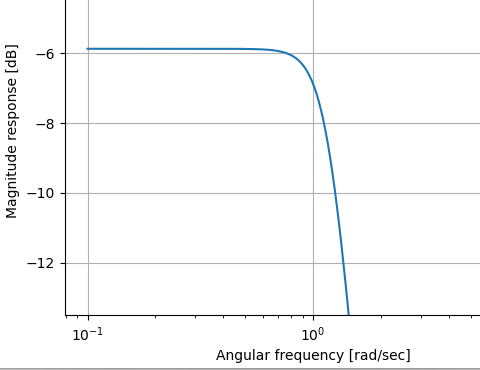
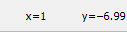

Ahora aplicamos el nucleo de transformacion $K(S) = \frac{1}{S}$

$$ T(S)_{HP} = \frac{S^4}{1.96522673S^4+4.33730373^3+4.78626802S^2+3.09395152SS+1} $$

Si lo acomodo un poco: 

$$ T(S)_{HP} = \frac{0.509S^4}{S^4+2.207S^3+2.435S^2+1.574S+0.509} $$

La caida de -6dB que vimos en la simulacion se da por la K de 0.508 que presenta el sistema. 

Chequeamos

[0.50890585 0.         0.         0.         0.        ]
[1.         2.20712468 2.43562341 1.57455471 0.50890585]
[-0.32320996+0.78035885j -0.32320996-0.78035885j -0.78035238+0.32307633j
 -0.78035238-0.32307633j]


(1,
 array([<AxesSubplot:title={'center':'Magnitude response'}, ylabel='Magnitude [dB]'>,
        <AxesSubplot:title={'center':'Phase response'}, xlabel='Angular frequency [rad/sec]', ylabel='Phase [deg]'>],
       dtype=object))

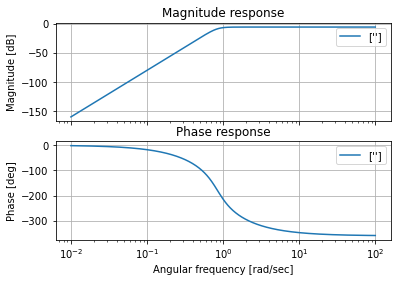

In [39]:
import numpy as np 
import scipy.signal as sig 
import math as m 
import splane as sp

num = [1]
den = [1, 3.094, 4.786, 4.337, 1.965]

num_hp,den_hp = sig.lp2hp(num,den,wp_n)

print(num_hp)
print(den_hp)
print(np.roots(den_hp)) 


myFilter = sig.TransferFunction(num_hp,den_hp)
sp.bodePlot(myFilter)


Lo que sigue es separar la expresion en dos SOS y asi poder implementar en el circuito pasivo: 

$$ T(S) = \frac{0.323^2+0.78^2S^2}{S^2+2*0.323S+0.323^2+0.78^2} \frac{0.323^2+0.78^2S^2}{S^2+2*0.78S+0.323^2+0.78^2} $$ 

$$ T(S) = \frac{0.712S^2}{S^2+0.646S+0.712} \frac{0.712S^2}{S^2+1.56S+0.712} $$ 

Sabemos que: 

$$ T(S)_{HP} = \frac{S^2}{S^2+S\frac{R}{L}+\frac{1}{LC}} $$ 

Tambien: 

$$ \omega_{01} = 0.844 $$ $$ Q_{1} = 1.31 $$ 
$$ \omega_{02} = 0.844 4 $$ $$   Q_{2} = 0.541 $$ 

Si tomo como $\Omega_{z} = L1 = L2 = 1Hy $ 


$$R2 = 1.56 \Omega$$
$$R1 = 0.646 \Omega$$
$$C2 = 1.4 F$$
$$C2 = 1.4 F$$



Circuito 


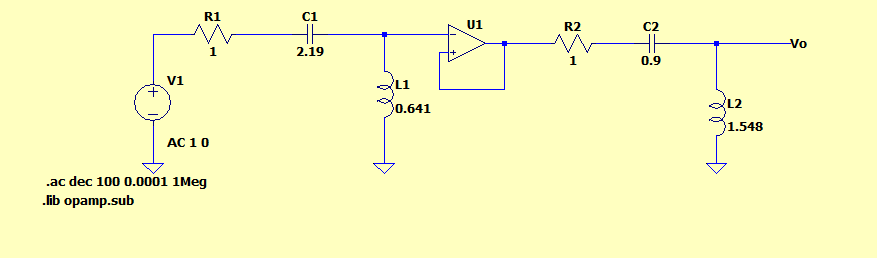

Simulacion normalizado 
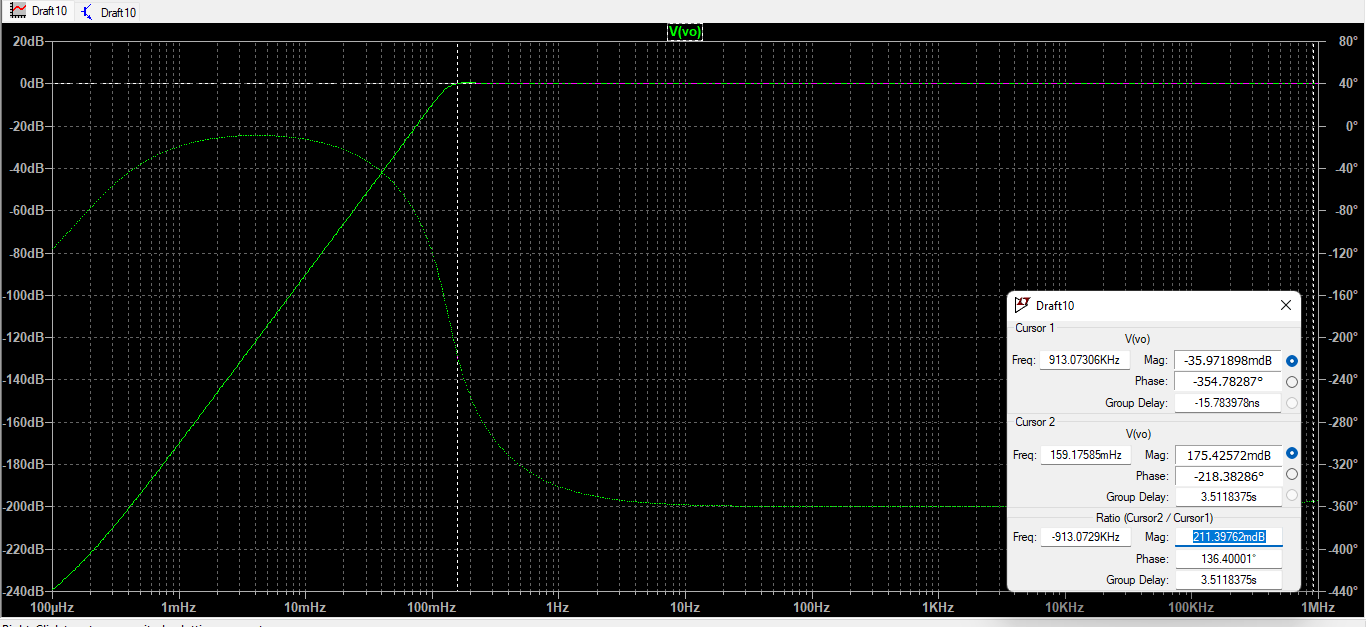
Componentes con $$ Z_{n} = 1K\Omega$$
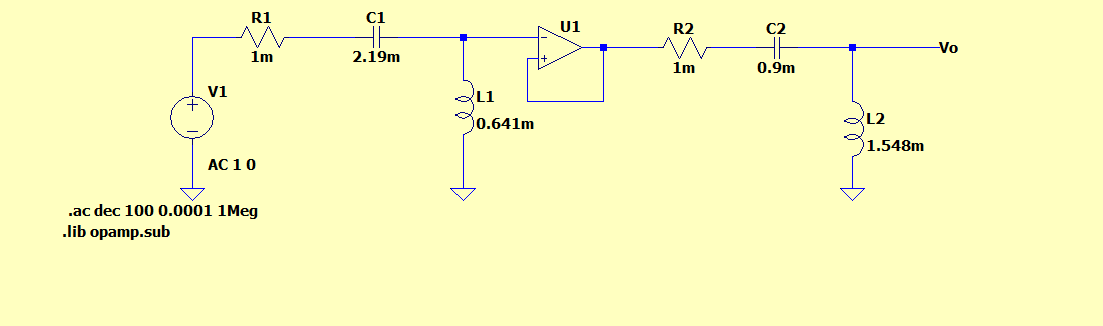
Componentes desnormalizados
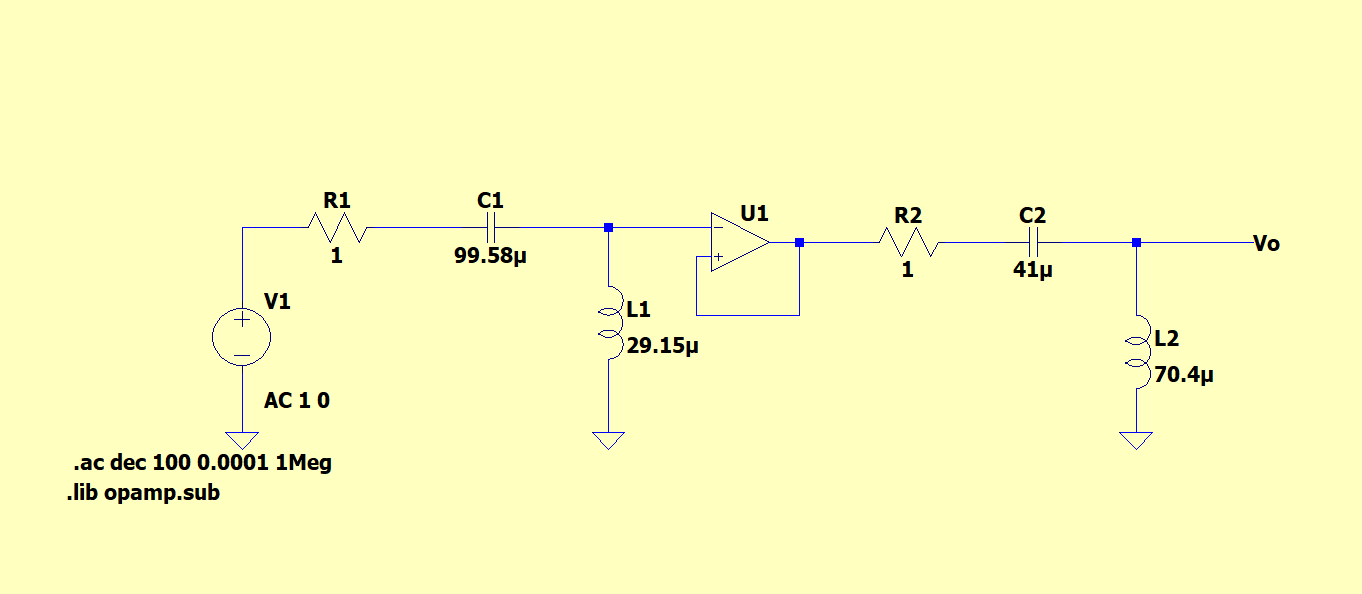
Simulacion desnormalizada
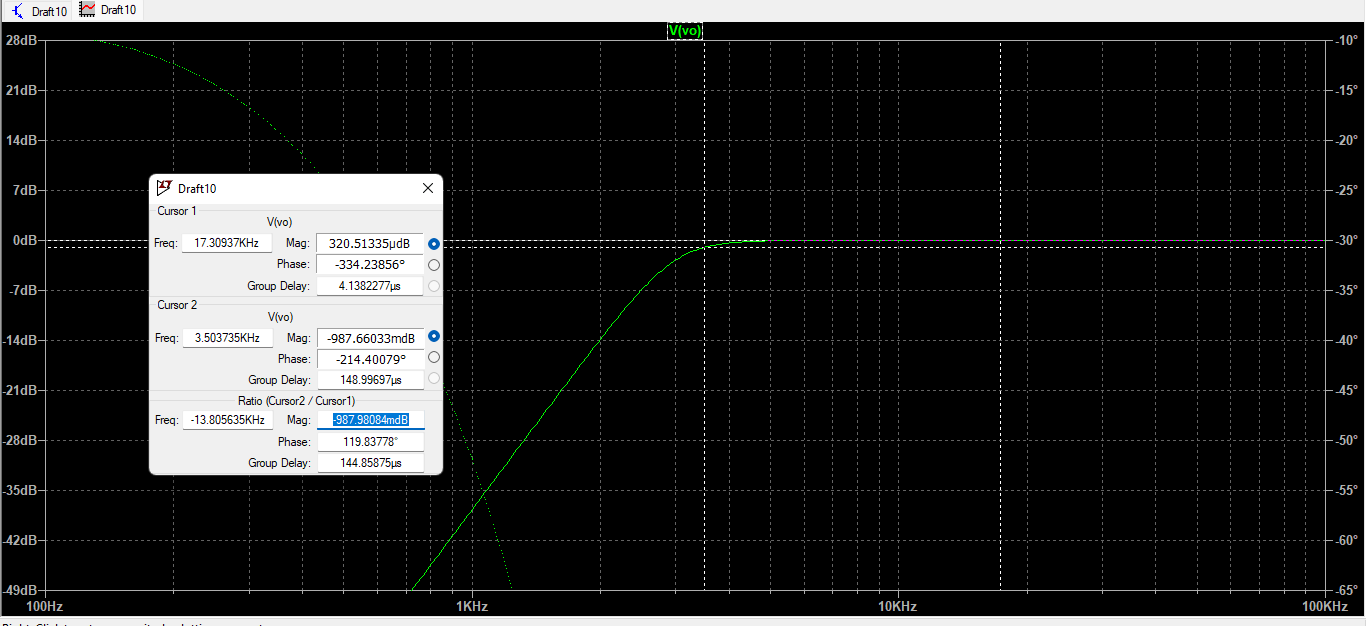
Atenuacion en 1KHz (Fstop) 
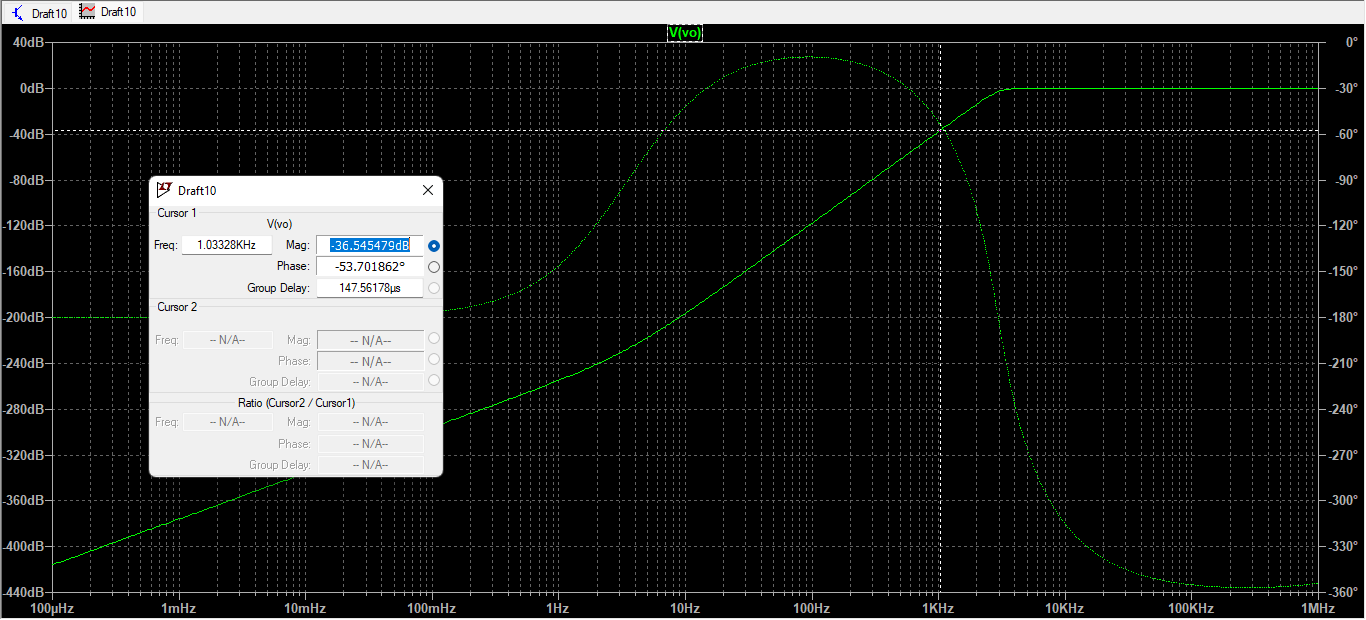

Por ultimo implementaremos el circuito mediante el GIC de Antoniou 

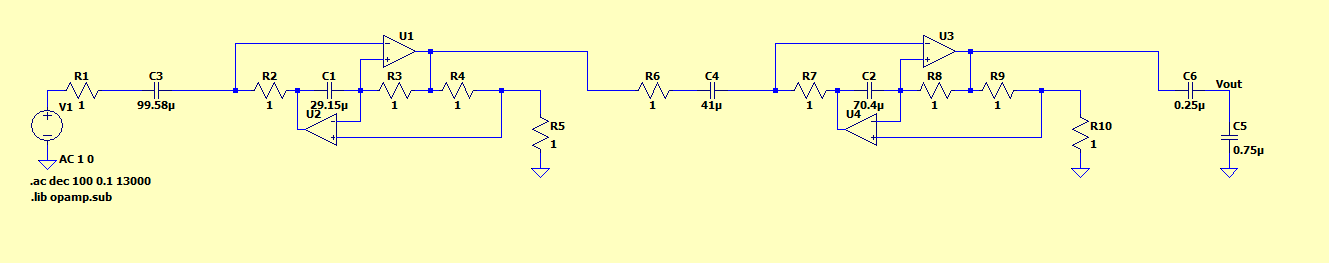

Es interesante tener en cuenta el divisor capacitivo en la salida para atenuar la ganancia de tension en cada una de las etapas. 

Con sus respectiva simulacion, marcando las frecuencias que nos interesan y atenuaciones: 
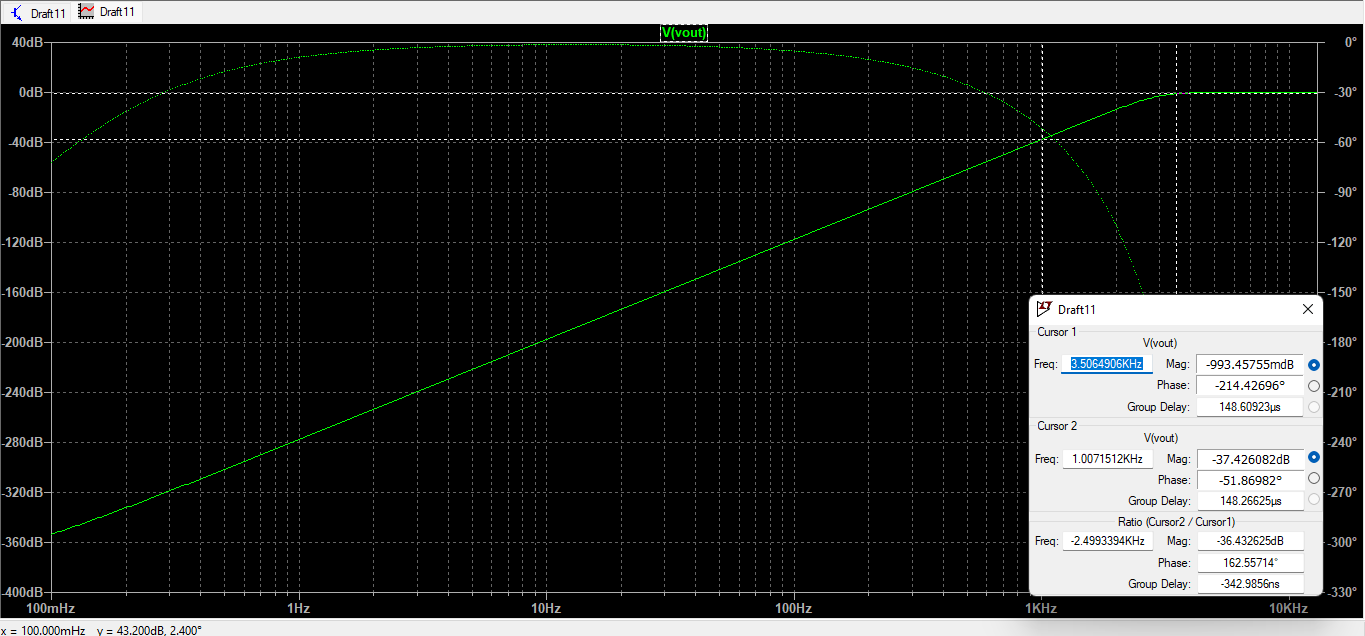